In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

<h3>(1) Simulate blocking system</h3>

In [22]:
def simulate_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10, n = 10000, 
                             arrival_mode = 'poisson', service_mode = 'exponential', service_params = {}):
    """
        Simulate simple blocking system with discrete events and no waiting room.
    """
    t_system = 0
    m = num_servers
    servers = np.zeros(m)
    blocked = 0 # Counter of number of blocked
    busy_servers = np.zeros(n, dtype=int)

    for i in range(n):
        # Sample time from which this customer arrives
        if arrival_mode == 'poisson':
            t_arrival = stats.expon.rvs(scale=arrival_intensity, size = 1)
        elif arrival_mode == 'erlang':
            t_arrival = stats.erlang.rvs(a = 2, scale=arrival_intensity / 2, size = 1)
        elif arrival_mode == 'hyper':
            t_arrival = rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0)
        else:
            raise ValueError('Wrong arrival mode specified!')
        
        # Extend system time
        t_system += t_arrival

        # Find available server
        min_server_idx = np.argmin(servers)

        if t_system >= servers[min_server_idx]:
            if service_mode == 'exponential':
                t_service = stats.expon.rvs(scale=mean_service_time, size = 1)
            elif service_mode == 'constant':
                t_service = mean_service_time
            elif service_mode == 'pareto':
                k = service_params.get('k')
                t_service = rvs_pareto(mean_ = mean_service_time, k = k, size = 1)
            elif service_mode == 'normal':
                s = service_params.get('s')
                val = stats.norm.rvs(loc = mean_service_time, scale = s, size = 1)
                if val < 0:
                    val = 0
                t_service = val
            else:
                raise ValueError('Wrong service mode specified')
            servers[min_server_idx] = t_system + t_service
        else:
            blocked += 1

        busy_servers[i] = np.sum(servers > t_system)

    # Compute blocked fraction
    blocked_fraction = blocked / n

    return blocked_fraction, busy_servers

def rvs_hyperexponential(p = 0.8, lambda_1 = 0.83, lambda_2 = 5.0, size = 1):    
    choices = stats.binom.rvs(p = 1 - p, n = 1, size = size)
    results = np.zeros(size)

    for i, choice in enumerate(choices):
        if choice == 0:
            results[i] =  stats.expon.rvs(scale = 1 / lambda_1, size = 1)    
        else:
            results[i] = stats.expon.rvs(scale = 1 / lambda_2, size = 1)

    return results

def rvs_pareto(mean_ = 8, k = 1.05, size = 1):
    # Find the value of Beta
    beta = mean_ * (k - 1) / k

    # Generate uniform numbers 
    U = np.random.uniform(0, 1, size = size)
    X = beta * (U ** (-1/k))

    return X

def confidence_interval(vals, alpha = 0.05):
    if type(vals) != np.ndarray:
        vals = np.array(vals)

    n = len(vals)

    mean_ = np.mean(vals)
    std_error = np.sqrt( 1 / (n - 1) * np.sum((vals - mean_) ** 2))

    t = stats.t.ppf(1 - (alpha / 2), df = n - 1 )

    conf = [mean_ - t * std_error / np.sqrt(n), mean_ + t * std_error / np.sqrt(n)]

    return np.array(conf)

def analytical_blocking_system(arrival_intensity = 1, mean_service_time = 8, num_servers = 10):
    lambda_ = arrival_intensity
    s = mean_service_time
    m = num_servers
    A = lambda_ * s

    temp = np.array([A ** i / np.math.factorial(i) for i in np.arange(0, m + 1, 1)])

    B = (A ** m / np.math.factorial(m)) / (temp.sum())

    return B


Compute analytical solution and compare to the confidence interval of the simulated solution

In [24]:
simulated_fractions = []

for i in range(10):
    blocked_fraction, busy_servers = simulate_blocking_system()
    simulated_fractions.append(blocked_fraction)

conf = confidence_interval(simulated_fractions)

analytical_blocked_fraction = analytical_blocking_system() 

print_conf = conf * 100

print(f'Simulated Blocked fraction confidence interval: [{print_conf[0]:.2f}%, {print_conf[1]:.2f}%]')
print(f'Analytical Blocked fraction: {analytical_blocked_fraction * 100:.2f}%')

Simulated Blocked fraction confidence interval: [11.81%, 13.08%]
Analytical Blocked fraction: 12.17%


The analytical solution is inside the confidence interval of the simulated solution, indicating that the simulation is performing well. We can also see how many servers are busy in steady state of the simulation to see if there are any errors. Here the number of busy servers are sampled each time we have an arrival.

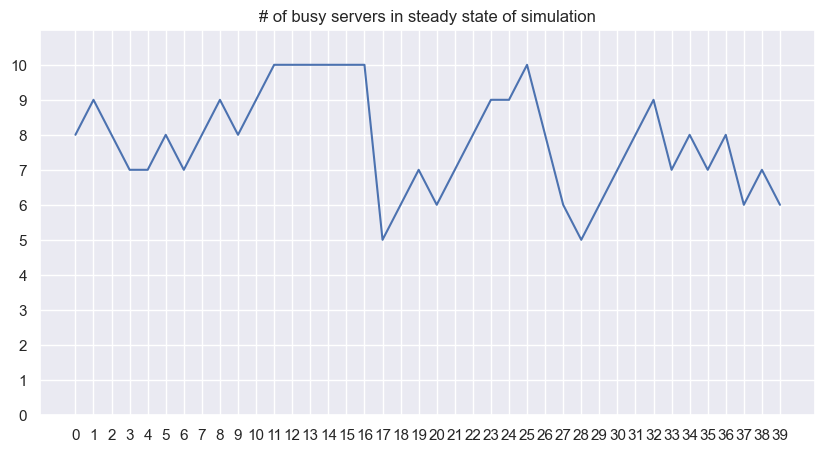

In [33]:
fig, ax = plt.subplots(1, figsize = (10, 5))
ax.set_xticks(np.arange(0, 40))
ax.set_yticks(np.arange(0, 11))
ax.set_ylim(0, 11)
ax.plot(busy_servers[1000:1040])
ax.set_title(f'# of busy servers in steady state of simulation')
plt.show()

<h3>(2) Experiment with different distributions of arrival time</h3>

We run simulations with each of the arrival functions 10 times and report a confidence interval of the blocked fraction.

In [36]:
def experiment_arrival_time_distributions():
    arrival_modes = ['poisson', 'erlang', 'hyper']

    print('Blocked fraction values of different arrival modes')
    print('-' * 50)
    for mode in arrival_modes:

        rounds = 10

        block_sims = np.zeros(rounds)

        for r in range(rounds):
            block_sims[r], _ = simulate_blocking_system(arrival_mode=mode)

        conf_int = confidence_interval(block_sims, alpha = 0.05)
        print_conf_int = conf_int * 100

        print(f'arrival mode: {mode}, conf_int = [{print_conf_int[0]:.2f}%, {print_conf_int[1]:.2f}%]')

experiment_arrival_time_distributions()

Blocked fraction values of different arrival modes
--------------------------------------------------
arrival mode: poisson, conf_int = [11.86%, 12.77%]
arrival mode: erlang, conf_int = [8.71%, 9.23%]
arrival mode: hyper, conf_int = [13.66%, 14.37%]


For the Erlang distribution we use values $k = 2 $ and $\lambda = \frac{1}{2}$ to get result that are different than that of the exponential distribution. We see that the confidence interval of the blocked fraction for this distribution is lower than the others wihile the hyperexponential has the highest estimate of the blocked fraction. We can plot histograms of the sampling distribution to understand why this might be the case.

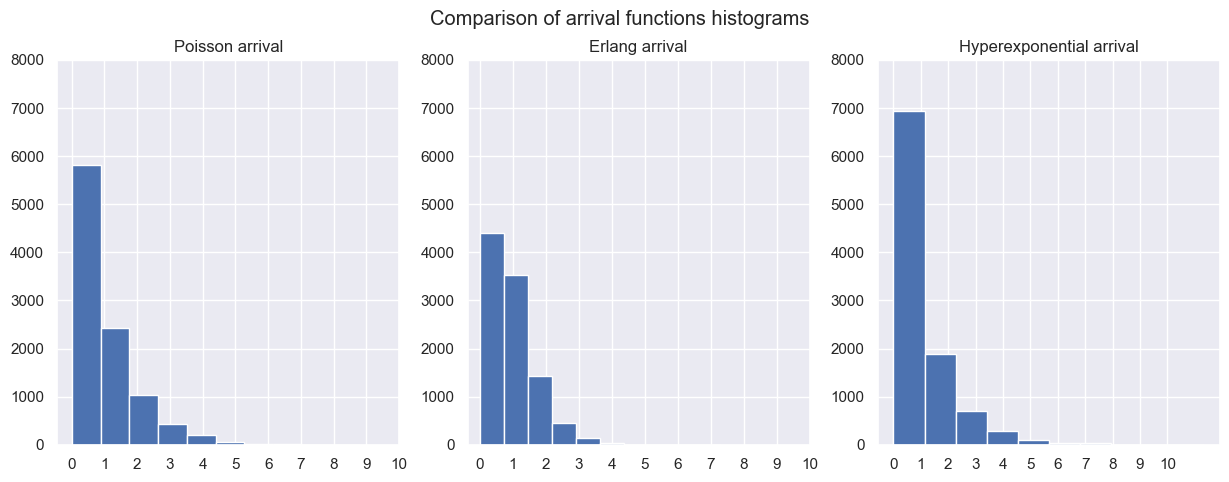

In [43]:
n_bins = 10
n_sample = 10000

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].hist(stats.expon.rvs(scale = 1, size = n_sample), bins = n_bins)
ax[1].hist(stats.erlang.rvs(a = 2, scale = 1 / 2, size = n_sample), bins = n_bins)
ax[2].hist(rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0, size = n_sample), bins = n_bins)

ax[0].set_title('Poisson arrival')
ax[1].set_title('Erlang arrival')
ax[2].set_title('Hyperexponential arrival')

for i in range(3):
    ax[i].set_xticks(np.arange(0, 11, 1))
    ax[i].set_ylim(0, 8000)

fig.suptitle('Comparison of arrival functions histograms')


plt.show()

We see from the plot above that for the hyperexponential the arrival time is lower than 1 time unit 70 % of the time, which would explain why the blocked fraction is the highest for this sampling distbrution. For the erlang arrival we see that the arrival times are distributed more evenly and consequently the servers will have more time to complete their tasks before the next arrival. 

<h3>(3) Experiment with different service-time distributions</h3>

We run the simulation ten times for each distribution for sampling service times and calculate the 95% confidence interval of the blocked fraction.

In [46]:
def experiment_service_mode_distributions():
    service_modes = ['exponential', 'constant', 'pareto', 'pareto', 'normal']
    service_params = [{}, {}, {'k' : 1.05}, {'k' : 2.05}, {'s' : 2}]

    print('Blocked fraction values of different service modes')
    print('-' * 50)
    for i, mode in enumerate(service_modes):

        rounds = 10

        block_sims = np.zeros(rounds)

        for r in range(rounds):
            block_sims[r],_ = simulate_blocking_system(service_mode=mode, service_params=service_params[i])

        conf_int = confidence_interval(block_sims, alpha = 0.05)
        print_conf_int = conf_int * 100

        print(f'service mode: {mode}, params: {service_params[i]}, conf_int = [{print_conf_int[0]:.2f}%, {print_conf_int[1]:.2f}%]')

experiment_service_mode_distributions()

Blocked fraction values of different service modes
--------------------------------------------------
service mode: exponential, params: {}, conf_int = [11.60%, 12.72%]
service mode: constant, params: {}, conf_int = [11.95%, 12.56%]
service mode: pareto, params: {'k': 1.05}, conf_int = [0.01%, 0.19%]
service mode: pareto, params: {'k': 2.05}, conf_int = [11.92%, 12.54%]
service mode: normal, params: {'s': 2}, conf_int = [11.57%, 12.18%]


We see similar results for the different service modes as for arrival times. For the pareto distribution with $k = 1.05$ we get next to no blocked customers. This is because, even though the mean of the distribution is the same as the others, it has a lot of very low service times and a low chance to get extremely high values. The simulation is robust to a few high service time samples as there are many servers available, which would explain why the blocked fraction is so low. This is not the case for pareto with $k = 2$ and the other distribution functions, which all have quite similar confidence intervals of the blocked fraction. The size of the confidence interval is the lowest for the constant service time (except pareto with $k = 1.05$), which makes sense as there is much less variability between each run.

<h3>(4) Compare differences in confidence intervals for prior tasks</h3>

In [9]:
experiment_arrival_time_distributions()
print()
experiment_service_mode_distributions()

Blocked fraction values of different arrival modes
--------------------------------------------------
arrival mode: poisson, conf_int = [11.57%, 12.48%]
arrival mode: erlang, conf_int = [9.05%, 9.67%]
arrival mode: hyper, conf_int = [13.01%, 14.12%]

Blocked fraction values of different service modes
--------------------------------------------------
service mode: exponential, params: {}, conf_int = [11.93%, 12.89%]
service mode: constant, params: {}, conf_int = [11.60%, 12.56%]
service mode: pareto, params: {'k': 1.05}, conf_int = [0.04%, 0.37%]
service mode: pareto, params: {'k': 2.05}, conf_int = [11.65%, 12.12%]
service mode: normal, params: {'s': 2}, conf_int = [11.88%, 12.12%]


See exercises (1) - (3) for comments on blocked fractions of the different arrival- and service distributions.